In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os

# 데이터 준비
df = pd.read_csv("data/bsmax_0_1", sep='\t')

# ymd 지우기
df = df.drop(['ymd'], axis=1)
print(df.head())
print(df.shape)
header = "init	rtn	avg	dev	bkmax	skmax	bomega	somega	bpri	bfor	bmom	bc	bpmax	bmax	bmomn	bcn	bpmaxn	bmaxn	spri	sfor	smom	sc	spmax	smax	smomn	scn	spmaxn	smaxn".split("\t")
print(header)


     init   rtn     avg   dev  bkmax  skmax  bomega  somega   bpri      bfor  \
0  192333  -500  192670  1452     12     14  -0.002   0.002 -0.277  2146.762   
1  192562 -4848  187788  1542      5      6   0.020   0.039 -0.385  5115.751   
2  188812 -2098  187049   574      4      7   0.001   0.001 -0.179  5378.637   
3  186556   944  187753   517      6      8   0.001  -0.001 -0.323  1546.270   
4  187794 -2982  185802   756     10     10  -0.001   0.001 -0.402  1937.626   

   ...   spri      sfor      smom      sc    spmax    smax   smomn    scn  \
0  ... -0.267  3284.428   412.228   9.682  315.230  23.000  10.655  0.052   
1  ... -0.404  6665.924  1028.882   8.776  721.892  30.500  10.915  0.032   
2  ... -0.228  2723.411   315.232  11.061  151.065  19.429   9.821  0.065   
3  ... -0.205  1627.165   208.041   8.732  216.675  23.125   8.048  0.056   
4  ... -0.129  2233.416   208.066  11.381   91.132  22.300   7.397  0.073   

     spmaxn  smaxn  
0  1293.851  0.000  
1  1239.855  6

In [ ]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.FloatTensor(sequences), torch.FloatTensor(targets)

seq_length = 10  # 시퀀스 길이
data = df.values

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)
sequences, targets = create_sequences(data_normalized, seq_length)
print(sequences.shape, targets.shape)

train_sequences, test_sequences, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, shuffle=True)

# 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = train_sequences.shape[2]
hidden_size = 100
num_layers = 3
output_size = train_targets.shape[1]

model = LSTM(input_size, hidden_size, num_layers, output_size)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_sequences)
    loss = criterion(outputs, train_targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_sequences)
            test_loss = criterion(test_outputs, test_targets)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(test_sequences)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

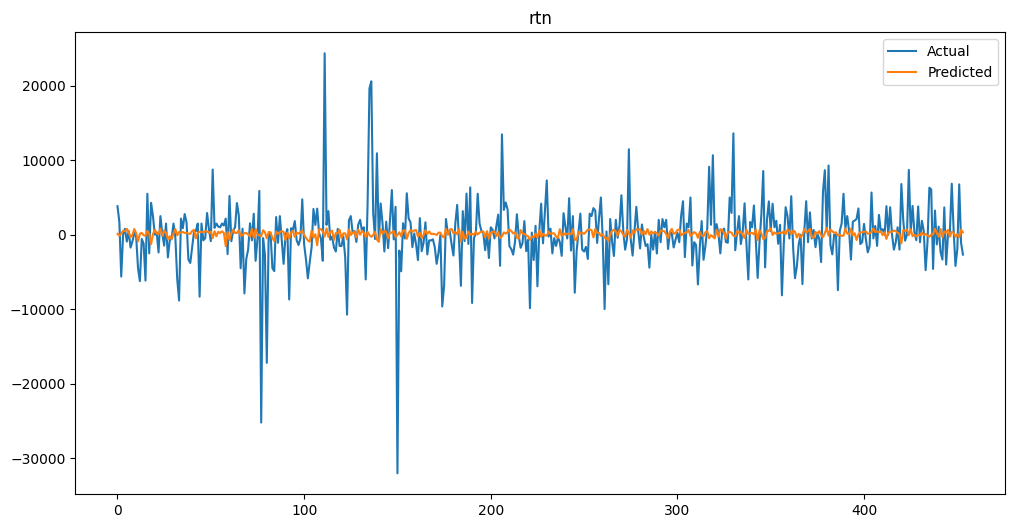

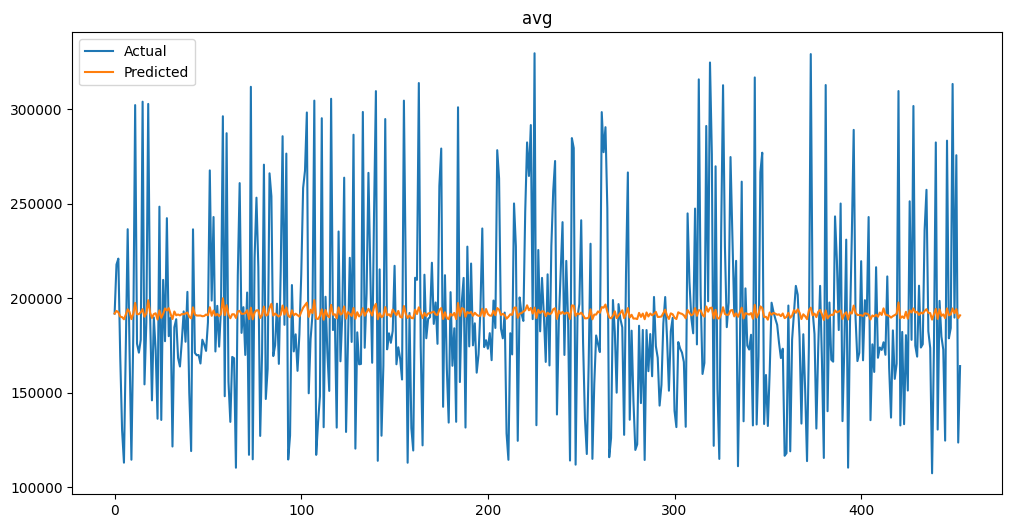

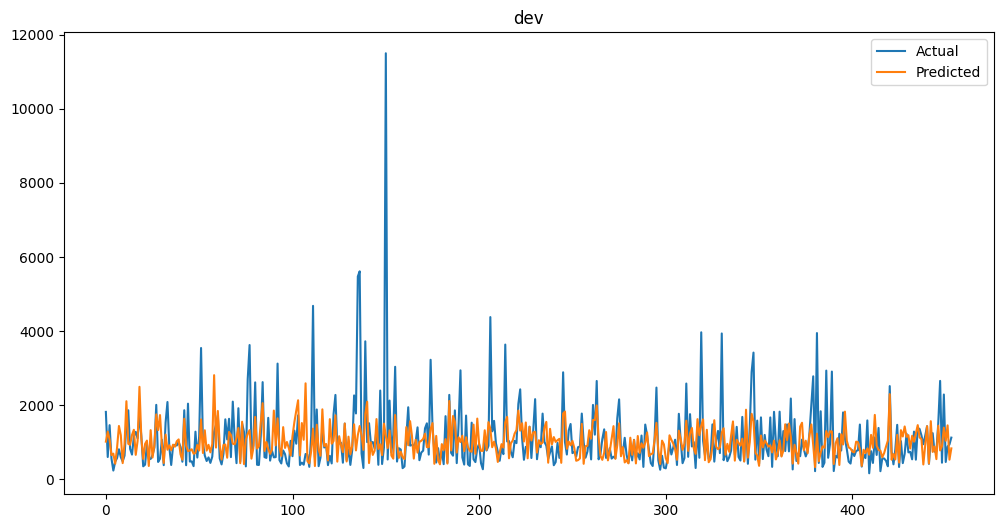

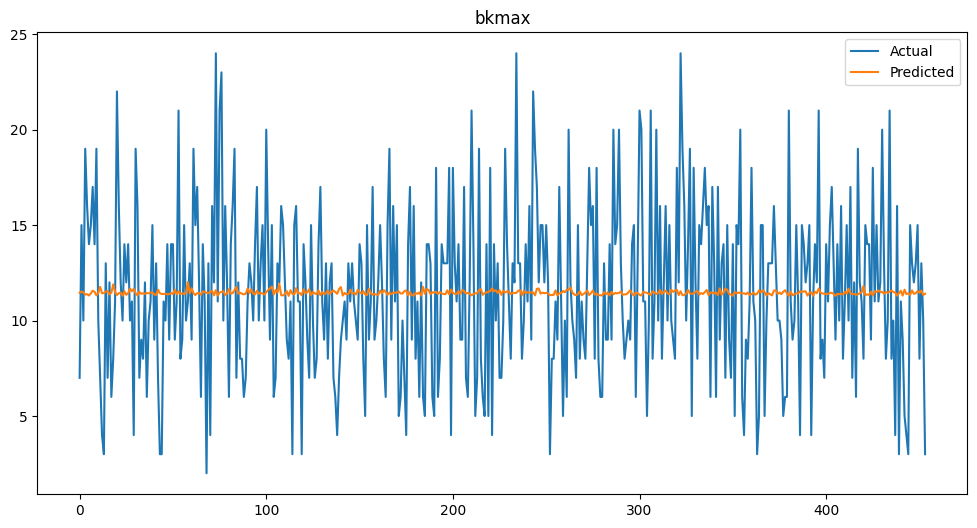

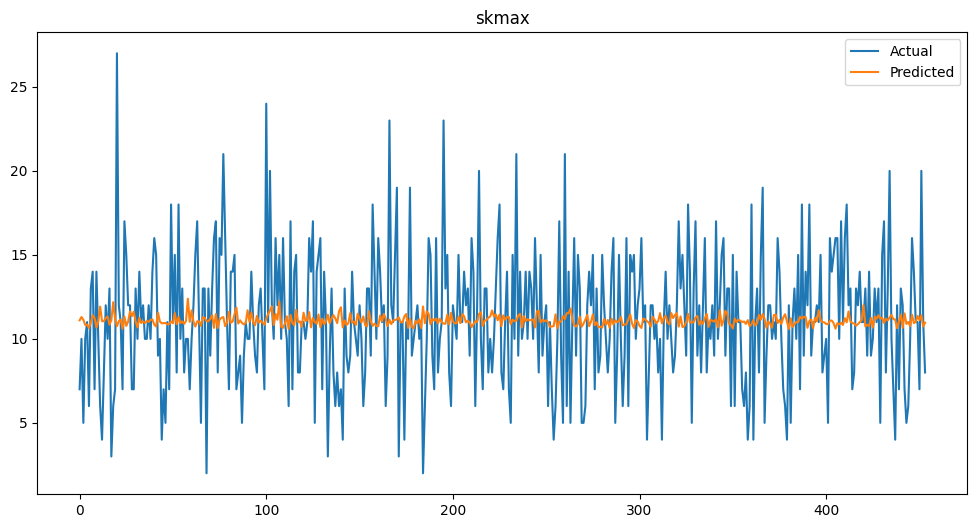

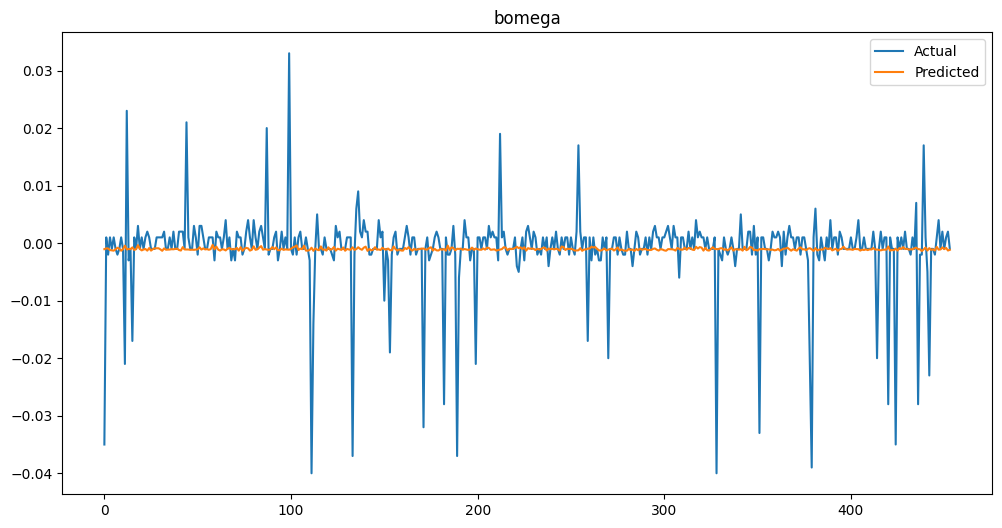

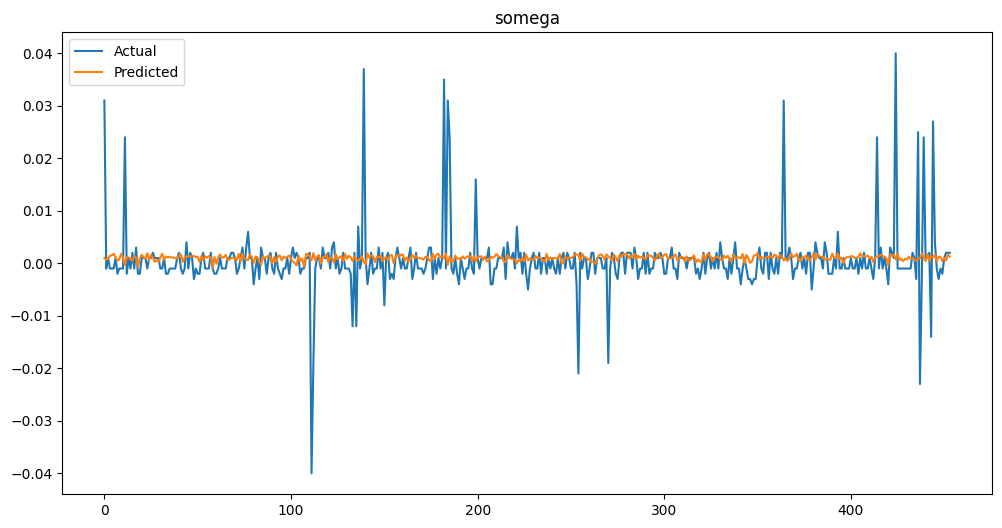

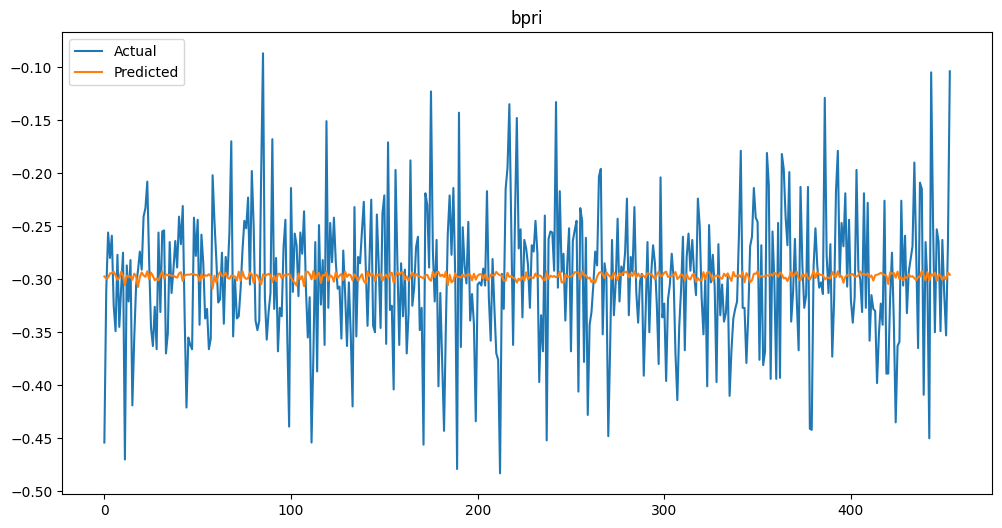

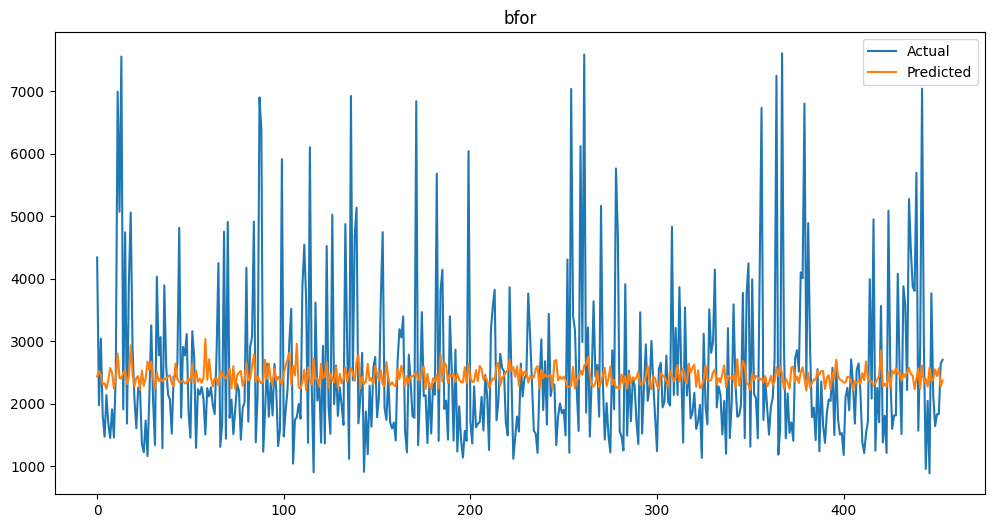

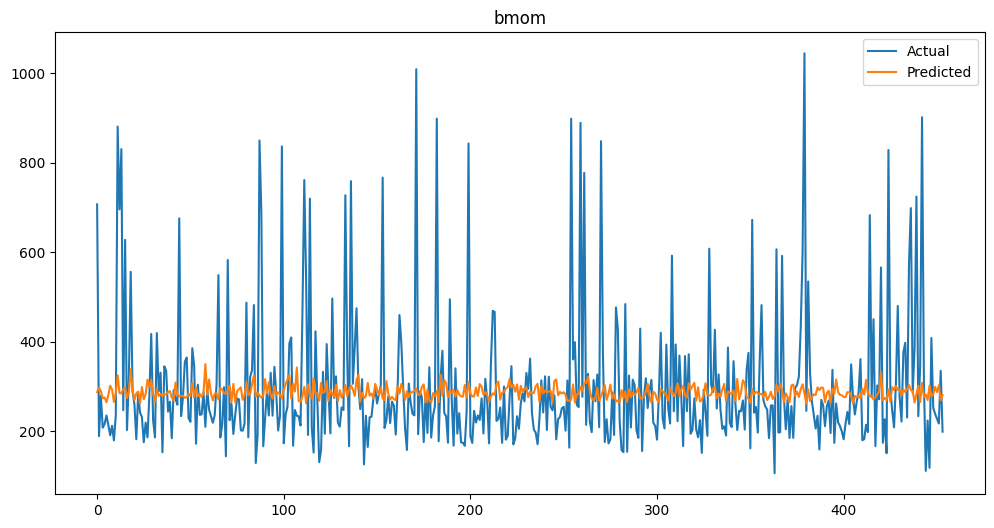

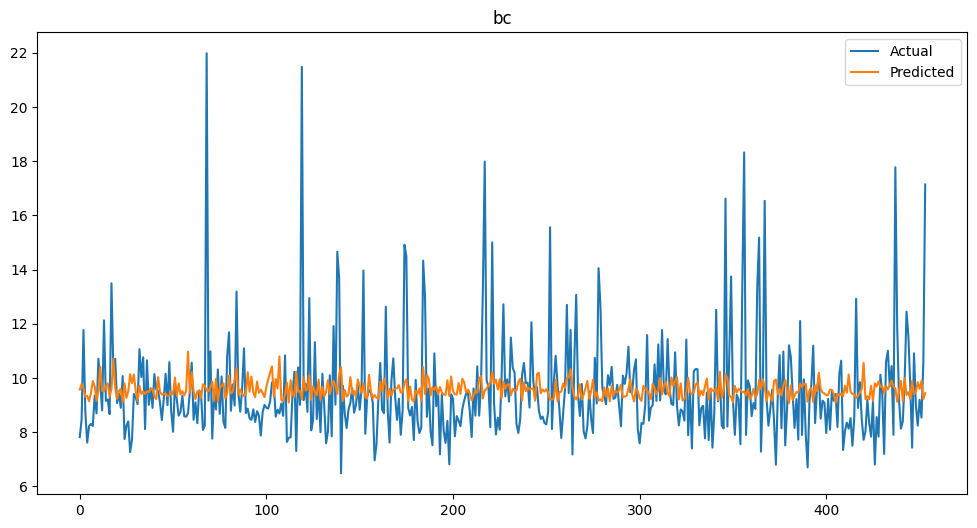

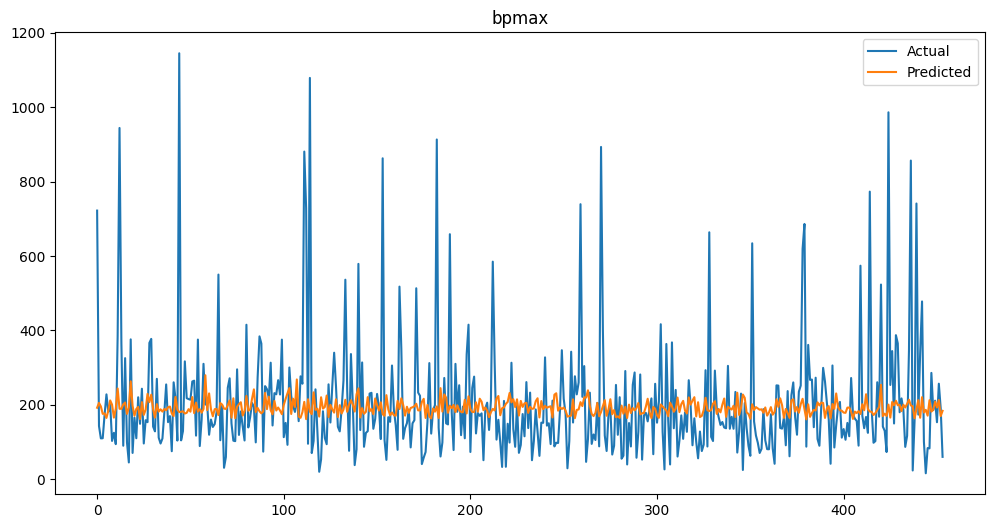

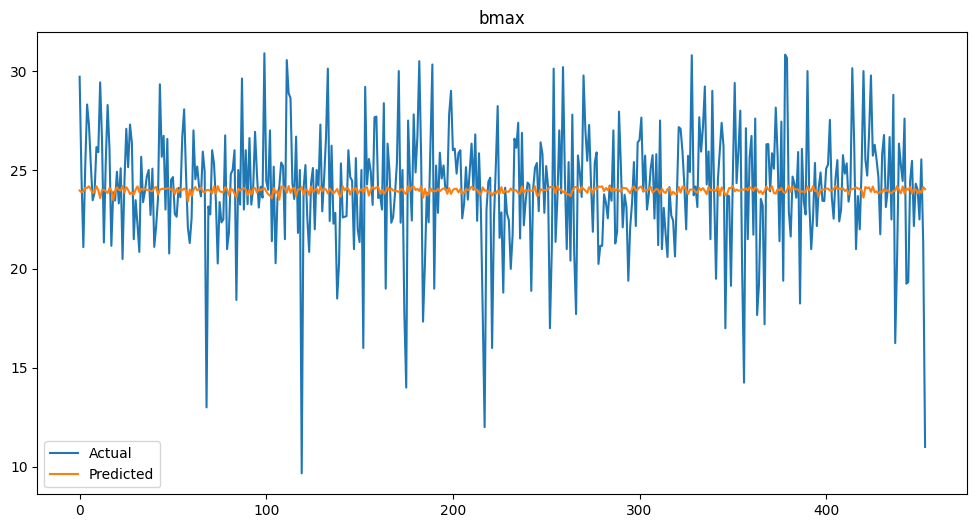

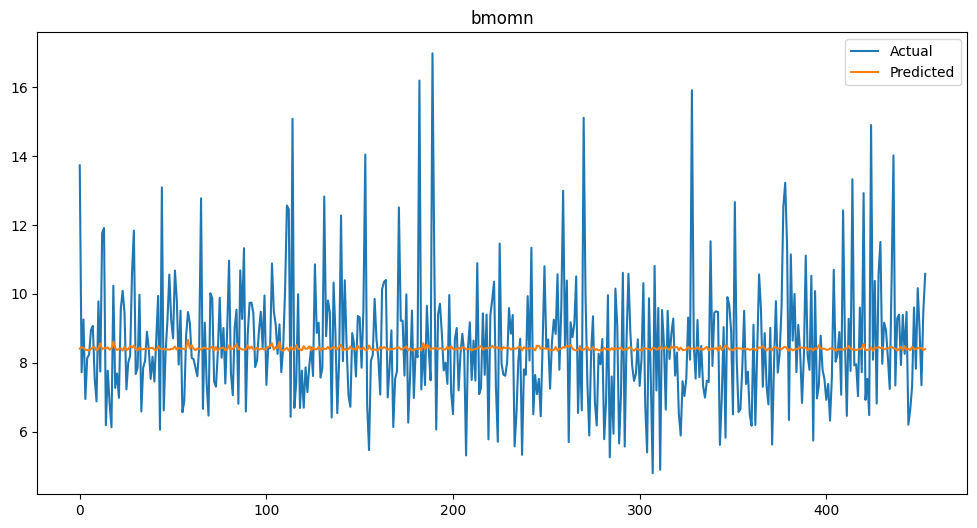

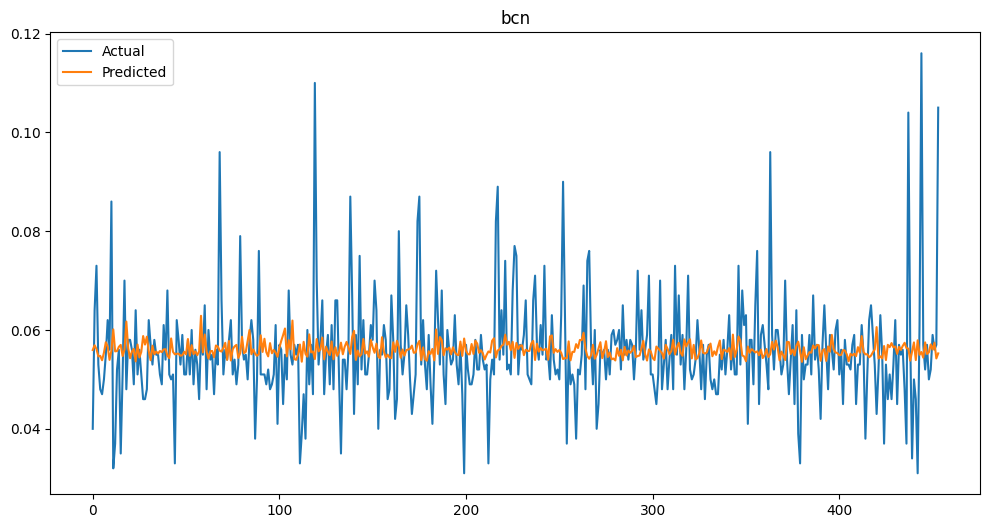

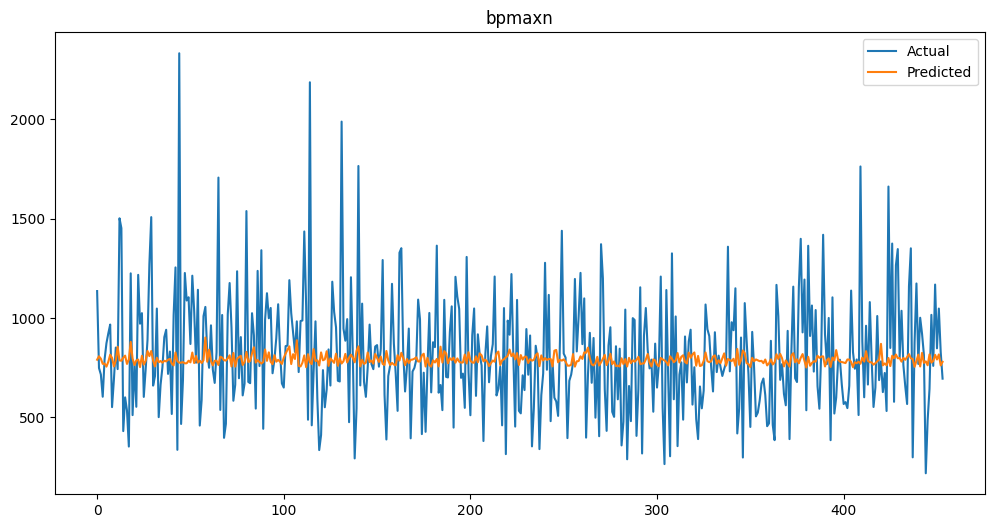

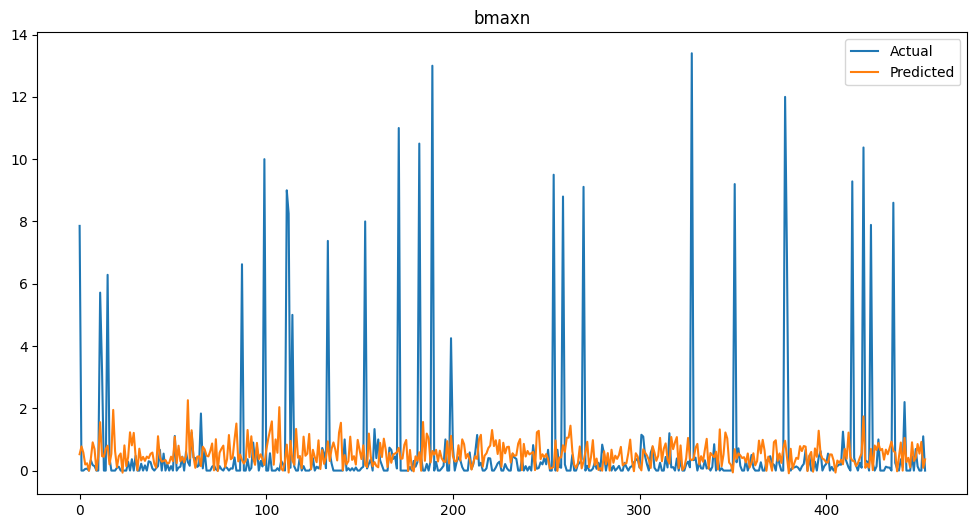

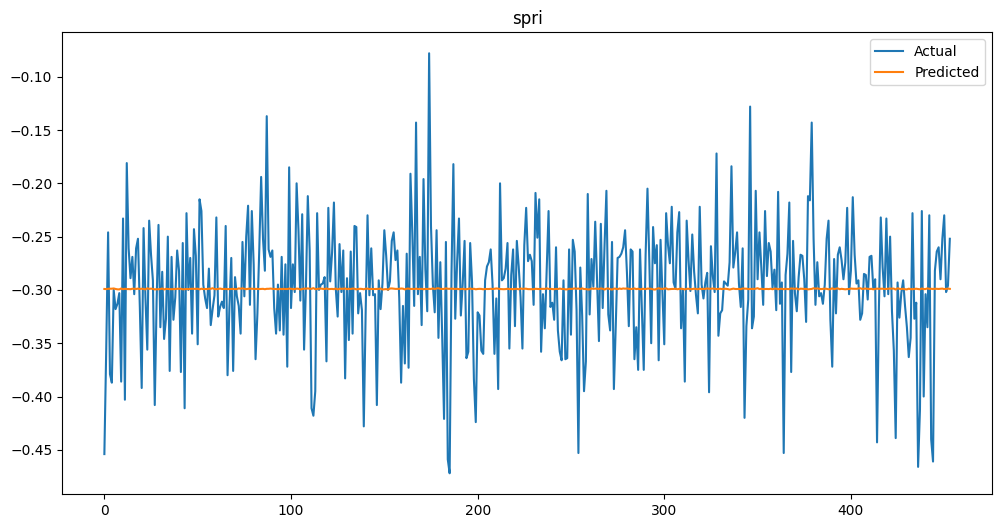

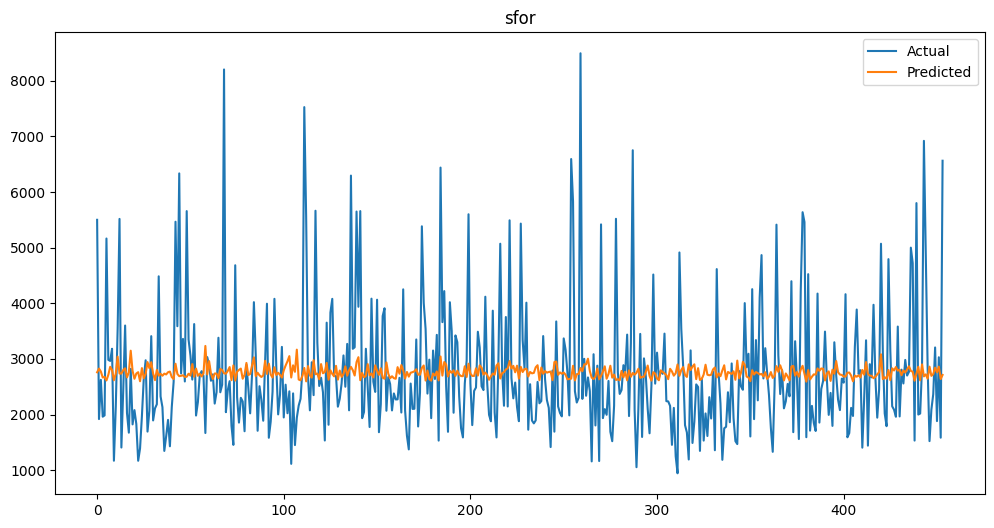

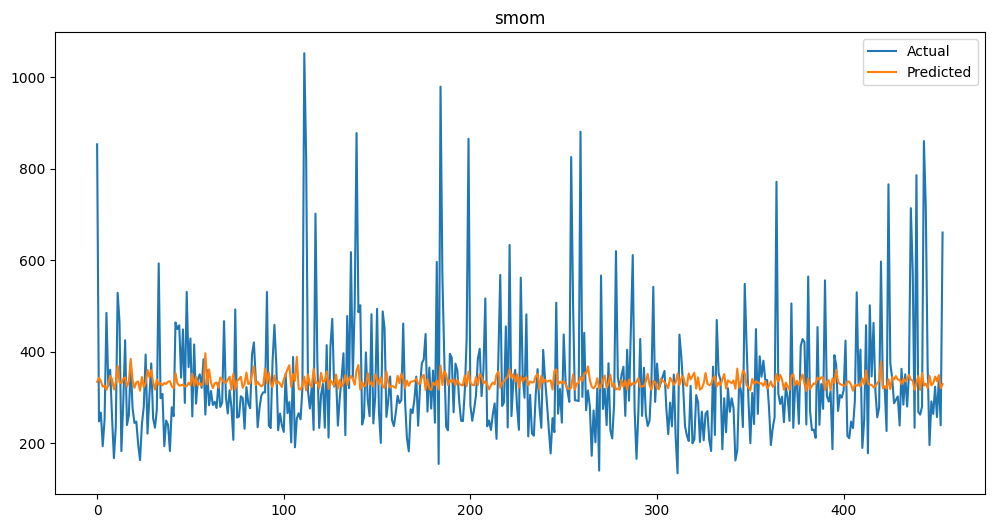

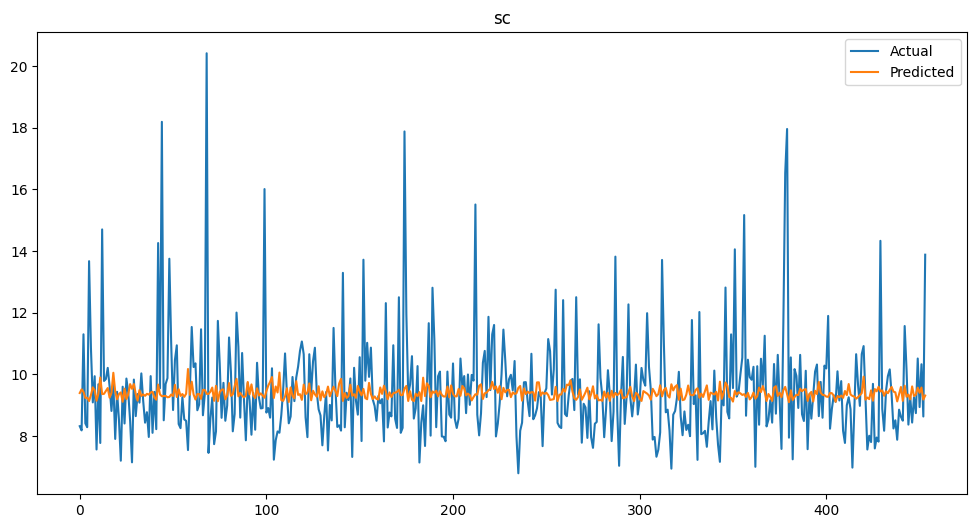

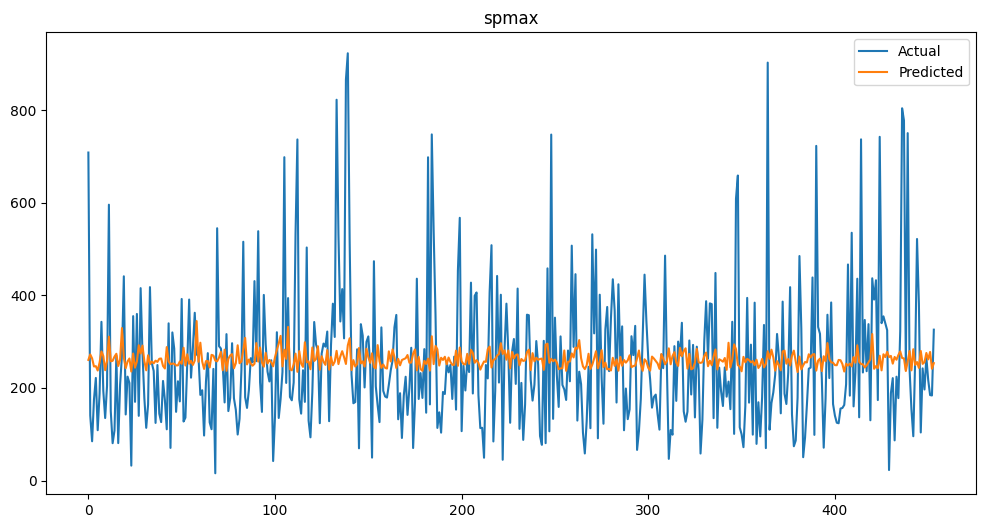

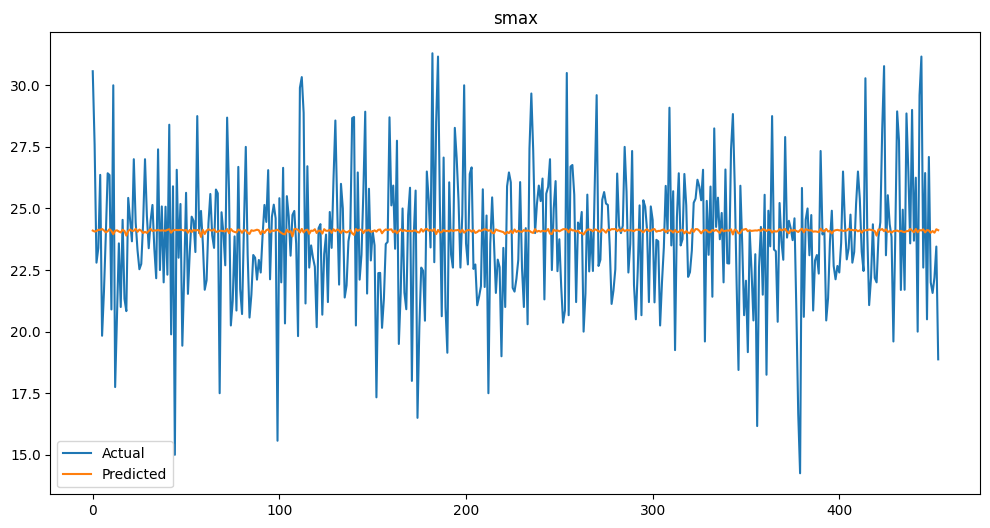

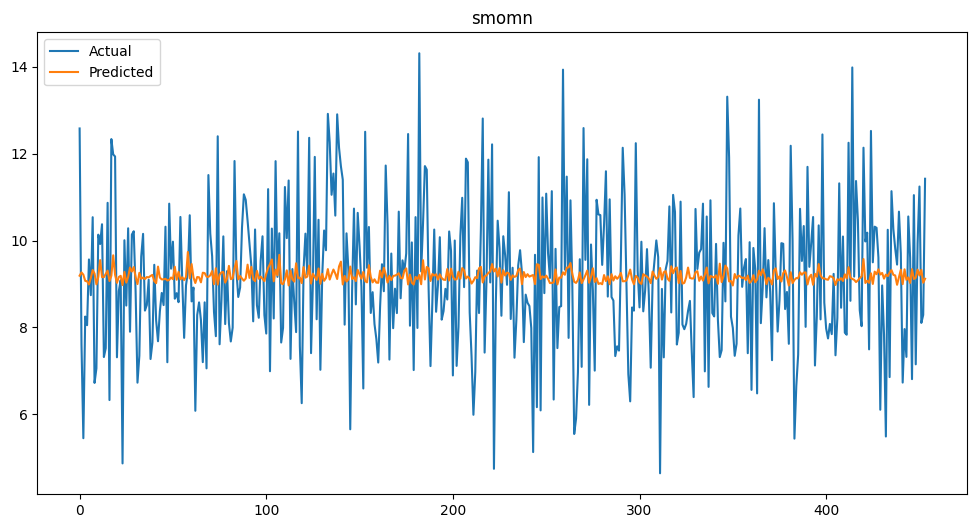

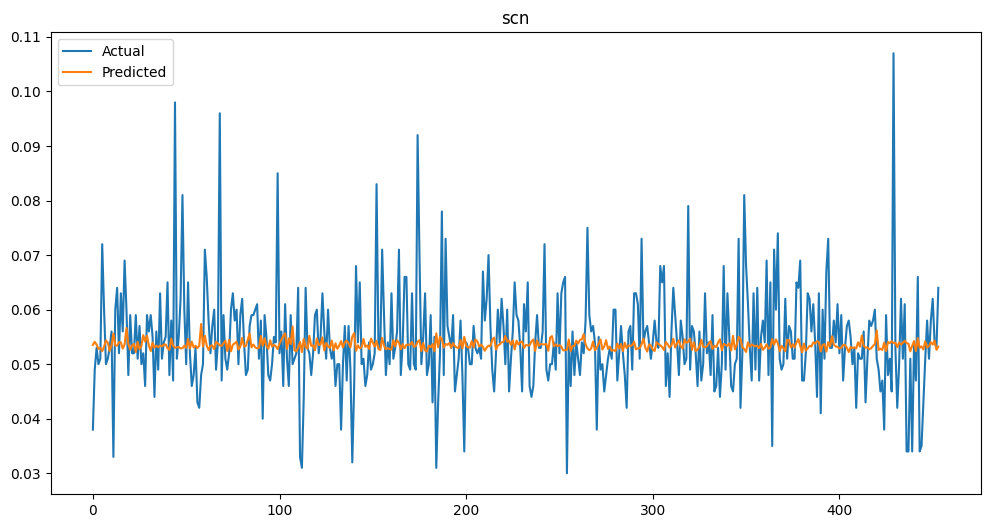

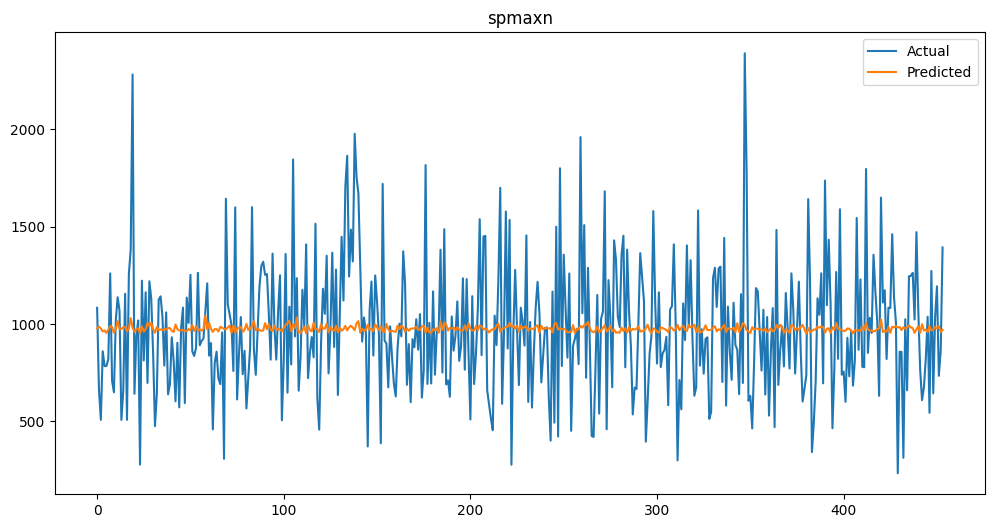

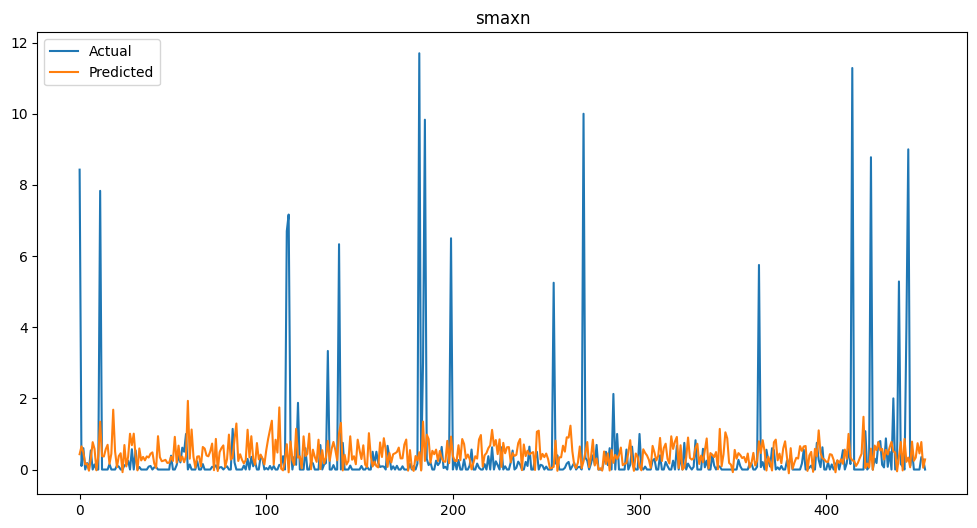

In [11]:
# 예측 결과 시각화 및 저장
predicted = test_outputs.cpu().numpy()
actual = test_targets.cpu().numpy()

# headers에 맞게 데이터를 정규화 해제합니다.
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)
header = "init	rtn	avg	dev	bkmax	skmax	bomega	somega	bpri	bfor	bmom	bc	bpmax	bmax	bmomn	bcn	bpmaxn	bmaxn	spri	sfor	smom	sc	spmax	smax	smomn	scn	spmaxn	smaxn".split("\t")

# 데이터 각각 시각화 및 저장
os.makedirs('result', exist_ok=True)
for i in range(1, len(header)):
    plt.figure(figsize=(12, 6))
    plt.plot(actual[:, i], label='Actual')
    plt.plot(predicted[:, i], label='Predicted')
    plt.title(header[i])
    plt.legend()
    plt.savefig(f'result/lstm_{header[i]}.png')
    plt.show()
    plt.close()


In [12]:
# Permutation Feature Importance 계산
def permute_feature_importance(model, test_sequences, test_targets, base_loss, feature_idx):
    permuted_sequences = test_sequences.clone()
    permuted_sequences[:, :, feature_idx] = permuted_sequences[:, torch.randperm(permuted_sequences.size(1)), feature_idx]
    with torch.no_grad():
        permuted_outputs = model(permuted_sequences)
        permuted_loss = criterion(permuted_outputs, test_targets)
    return permuted_loss.item() - base_loss.item()

model.eval()
with torch.no_grad():
    base_test_outputs = model(test_sequences)
    base_test_loss = criterion(base_test_outputs, test_targets)
    print(f'Test Loss: {base_test_loss.item():.4f}')



Test Loss: 0.0695


Feature names length: 28
Feature importances length: 28


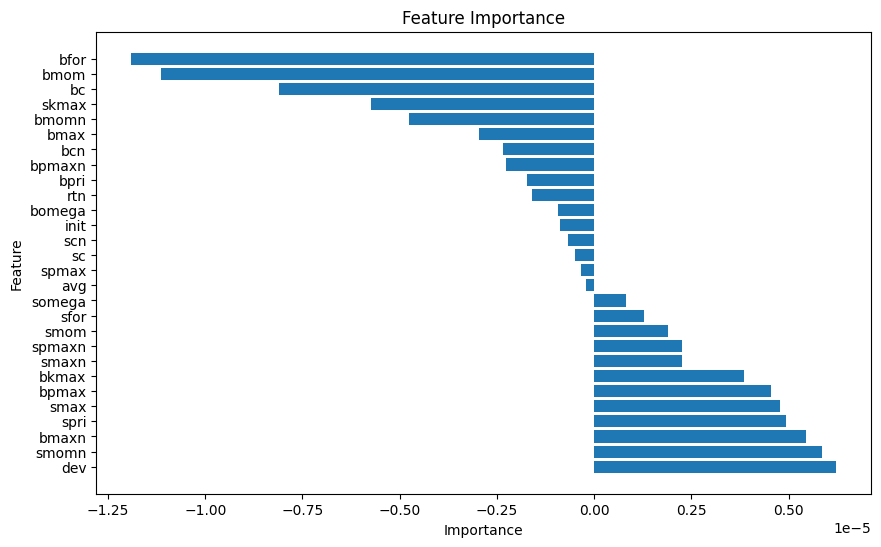

In [14]:

feature_importances = []
for i in range(input_size):
    importance = permute_feature_importance(model, test_sequences, test_targets, base_test_loss, i)
    feature_importances.append(importance)

# 헤더에 맞게 변수 이름 설정
feature_names = header[0:input_size+1]
print(f"Feature names length: {len(feature_names)}")
print(f"Feature importances length: {len(feature_importances)}")

if len(feature_names) != len(feature_importances):
    raise ValueError("Feature names and feature importances length do not match. Please check the input data and header.")

# 중요도 시각화 및 저장
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig('result/lstm_feature_importance.png')
plt.show()

이 그래프는 LSTM 모델을 사용하여 시계열 데이터를 예측할 때 각 변수의 중요도를 보여줍니다. Permutation Feature Importance 기법을 사용하여 계산된 이 그래프는 각 변수를 무작위로 섞었을 때 모델의 성능이 얼마나 감소하는지를 나타냅니다.

### 그래프 해석 방법:

1. **X축 (Importance)**:
   - 변수의 중요도 점수입니다. 이 값은 변수를 무작위로 섞었을 때 모델의 성능 손실을 측정합니다. 음수 값은 변수를 섞었을 때 모델의 성능이 더 나빠졌다는 것을 의미합니다. 즉, 해당 변수가 예측에 중요하다는 것을 나타냅니다.
   - 중요한 변수일수록 값이 음수로 더 크며, 덜 중요한 변수일수록 값이 작거나 0에 가깝습니다.

2. **Y축 (Feature)**:
   - 변수 이름을 나타냅니다.

### 주요 포인트:

- **중요한 변수**:
  - **bfor**, **bmom**, **bc** 등의 변수는 모델 예측에 큰 영향을 미치고 있습니다. 이들은 X축에서 음수 값이 크며, 변수를 섞었을 때 모델의 성능이 크게 감소함을 나타냅니다.
  
- **덜 중요한 변수**:
  - **dev**, **smomn**, **bmaxn** 등의 변수는 모델 예측에 상대적으로 덜 중요한 변수입니다. 이들은 X축에서 음수 값이 작거나 0에 가깝습니다.

### 해석:

- **중요도가 높은 변수**는 모델이 예측할 때 많이 참고하는 변수들입니다. 이 변수들이 예측 성능에 큰 영향을 미친다는 것을 의미합니다. 따라서, 예측 성능을 향상시키기 위해서는 이 변수들을 잘 이해하고 관리하는 것이 중요합니다.
  
- **중요도가 낮은 변수**는 모델이 예측할 때 크게 참고하지 않는 변수들입니다. 이러한 변수들은 예측 성능에 큰 영향을 미치지 않으므로, 필요에 따라 데이터를 단순화하거나 분석을 줄이는 데 참고할 수 있습니다.

이 그래프를 통해 LSTM 모델이 어떤 변수에 더 의존하는지 이해하고, 모델의 성능을 개선하기 위한 인사이트를 얻을 수 있습니다. 중요한 변수들을 더 집중적으로 분석하고, 덜 중요한 변수들은 필요에 따라 조정하거나 제거할 수 있습니다.